# Practicing with pymc

Working with pymc can be difficult. All programming problems force you to engage with obscure errors but pymc errors can be especially obscure. We can help you, Akshay and I. But the best approach is to just run head first into a few and practice correcting your code. I want to start off class today by repeating an exercise from last lecture, except you'll do half of it on your own. 

Below is code to (1) extract the treatment group data and (2) estimate the beta-binomial model on that data. Your job is to extract the control group data and estimate the beta-binomial model on that. Then we'll compare the two groups. Solutions for all of this can be found in Lecture 13 so if you get stuck, that's a place to check. But try to do as much on your own.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pymc as pm
import arviz as az

url = "https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/Asch_experiment_1_data"

data = pd.read_csv(url)

Below is how we extract the treatment group. But how do we extract the control group data?

In [10]:
n = 12

# treatment group

data_treatment = data[data.treatment == 1]
k_treatment = list(data_treatment.mistakes.values)

In [ ]:
# control group

Here is the pymc code to estimate the beta-binomial on the treatment. What changes do we need to make to estimate the control? It would be really nice if we could compare the two models later on, so try to write your code so it doesn't save over names we used in the first estimation.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, d]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


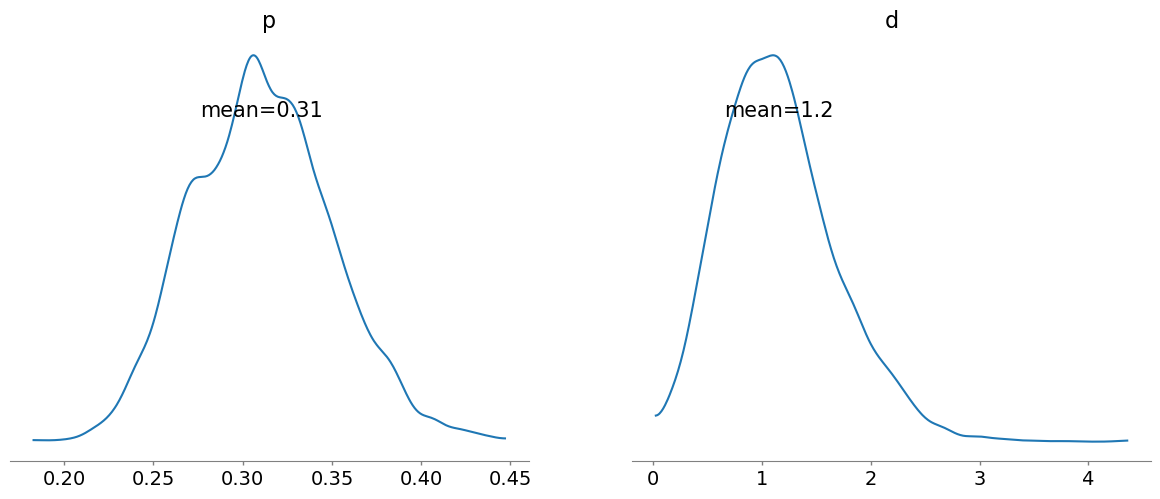

In [11]:
with pm.Model() as m1:
    p = pm.Beta('p',alpha=1,beta=1)
    d = pm.Exponential('d',1/150) + 1
    
    a = p*d
    b = (1-p)*d
    
    y = pm.BetaBinomial('y',n=12,alpha=a,beta=b,observed=k_treatment)
    
    trace1 = pm.sample()
    
az.plot_posterior(trace1,hdi_prob='hide');

In [ ]:
# control group

Finally we want to compare the two groups. This entails taking the posterior distributions over both parameters and pushing them through a `stats.betabinom().rvs()` function to create predictions for future hypothetical experiments. Try to get predictions for both groups.

Finally, we want to get a histogram to compare the two sets of predictions. Subtract one batch of predictions from the other and plot it.

# Sample size in the asch study


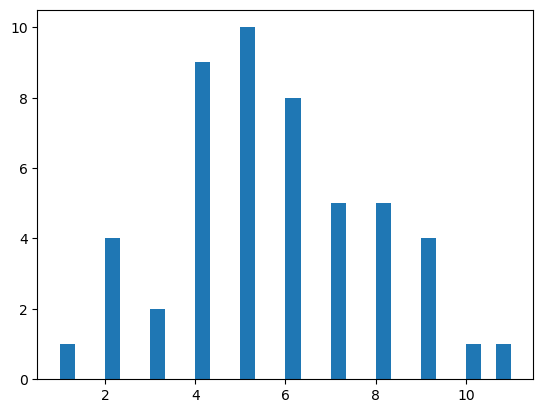

In [13]:
sample_size = 50
p = 0.5
d = 10

data = stats.betabinom(n=12,a=p*d,b=(1-p)*d).rvs(sample_size)

plt.hist(data,bins=30);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, d]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


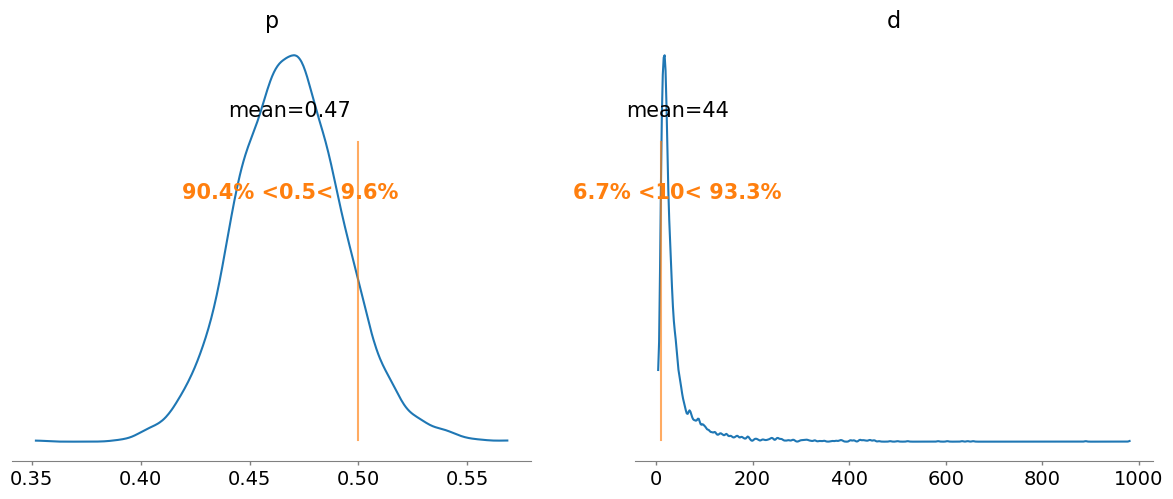

In [14]:
with pm.Model() as m0:
    p = pm.Beta('p',alpha=1,beta=1)
    d = pm.Exponential('d',1/150) + 1
    
    a = p*d
    b = (1-p)*d
    
    y = pm.BetaBinomial('y',n=12,alpha=a,beta=b,observed=data)
    
    trace = pm.sample()
    
az.plot_posterior(trace,ref_val=[0.5,10.0],hdi_prob='hide');

## fixing the posterior display

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, d_minus_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


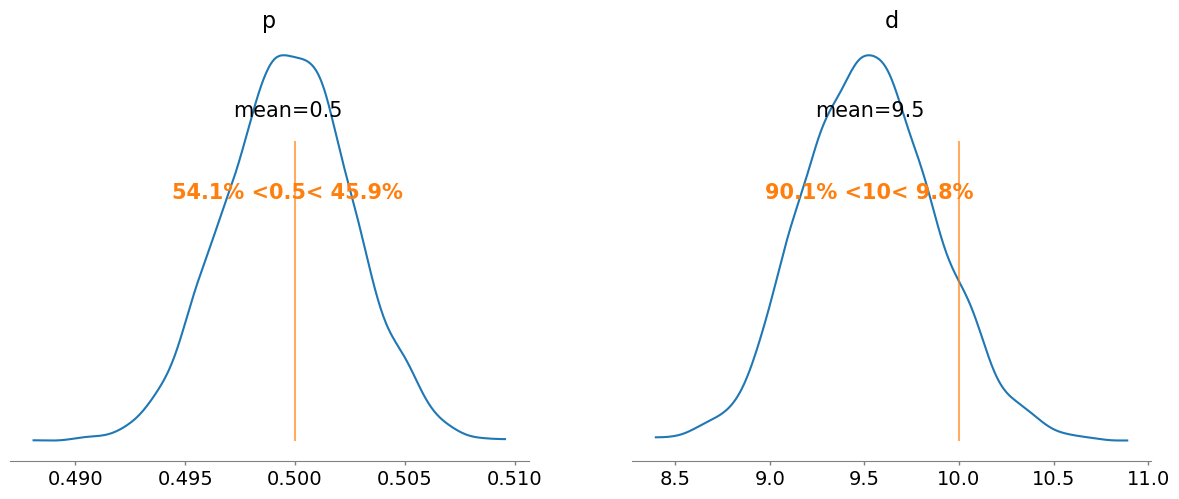

In [20]:
with pm.Model() as m0:
    p = pm.Beta('p',alpha=1,beta=1)
    d_minus_one = pm.Exponential('d_minus_one',1/150)
    d = pm.Deterministic('d',d_minus_one + 1)
    
    a = p*d
    b = (1-p)*d
    
    y = pm.BetaBinomial('y',n=12,alpha=a,beta=b,observed=data)
    
    trace = pm.sample()
    
az.plot_posterior(trace,var_names=['p','d'],ref_val=[0.5,10.0],hdi_prob='hide');

# Sample size and effect size

Normally, we are not interested in just learning the parameter for one group of people. In your typical cognitive science experiment, we are interested in *comparing* two groups. Let's apply the same technique to comparisons. The goal is to figure out, how different the error rates of these two groups of people.

In [24]:
# specify group 1

sample_size_1 = 50
p1 = 0.5
d1 = 10

# specify group 2

sample_size_2 = 34
p2 = 0.4
d2 = 50

# simulate data for both

data1 = stats.betabinom(n=12,a=p1*d1,b=(1-p1)*d1).rvs(sample_size_1)
data2 = stats.betabinom(n=12,a=p2*d2,b=(1-p2)*d2).rvs(sample_size_2)

In [25]:
with pm.Model() as m0:
    p1 = pm.Beta('p1',alpha=1,beta=1)
    d1 = pm.Exponential('d1',1/150) + 1
    p2 = pm.Beta('p2',alpha=1,beta=1)
    d2 = pm.Exponential('d2',1/150) + 1
    
    a1 = p1*d1
    b1 = (1-p1)*d1
    a2 = p2*d2
    b2 = (1-p2)*d2
    
    y = pm.BetaBinomial('y1',n=12,alpha=a1,beta=b1,observed=data1)
    y = pm.BetaBinomial('y2',n=12,alpha=a2,beta=b2,observed=data2)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p1, d1, p2, d2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


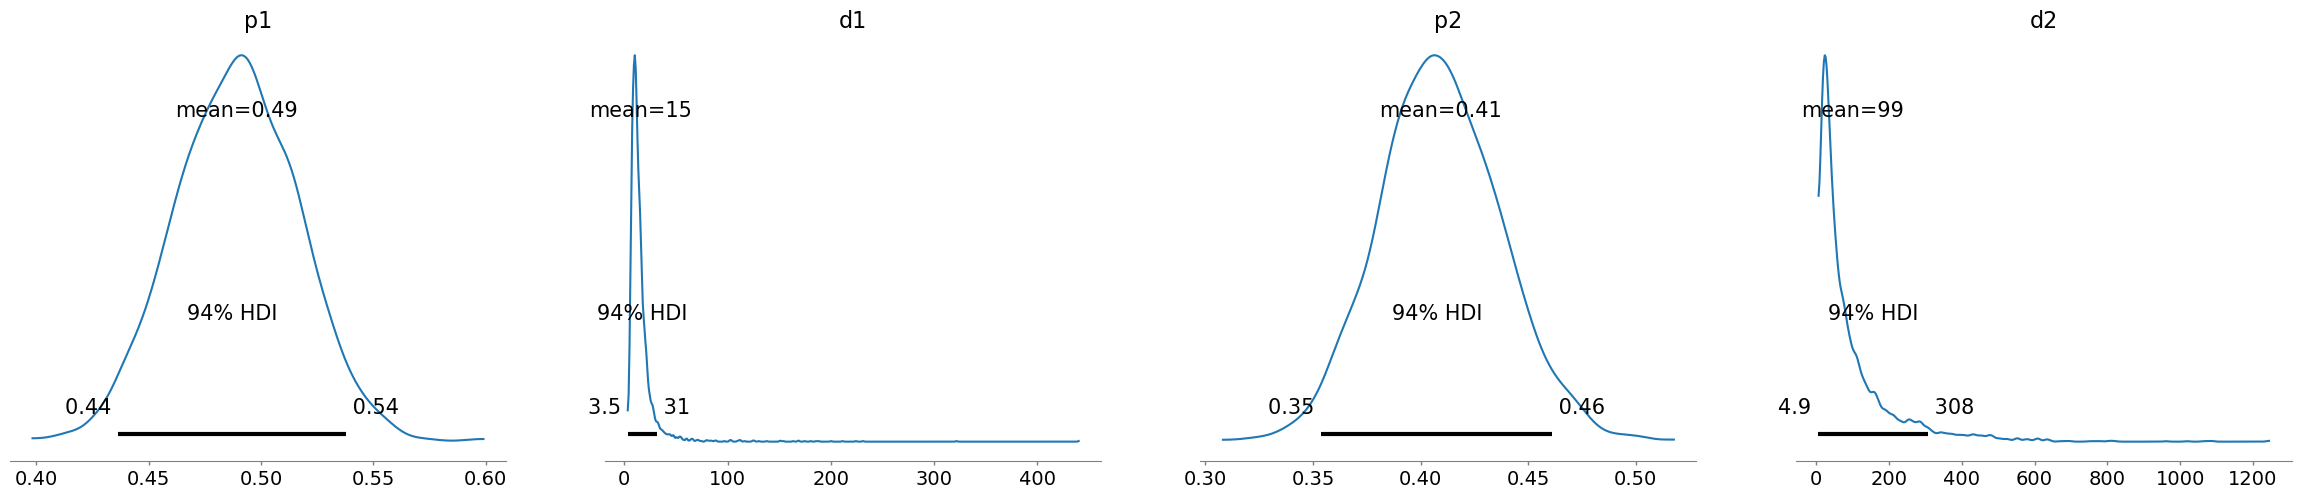

In [26]:
az.plot_posterior(trace);

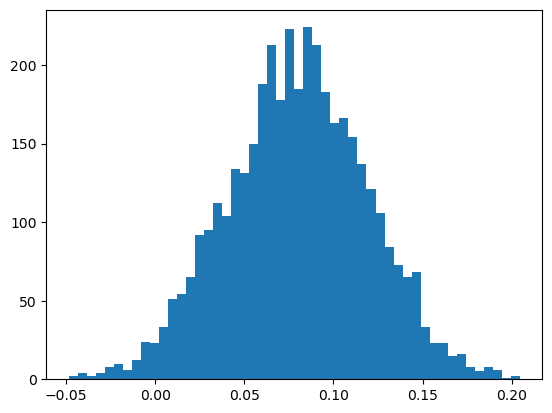

In [30]:
p1 = trace.posterior['p1'].values.flatten()
p2 = trace.posterior['p2'].values.flatten()

plt.hist(p1-p2,bins=50);

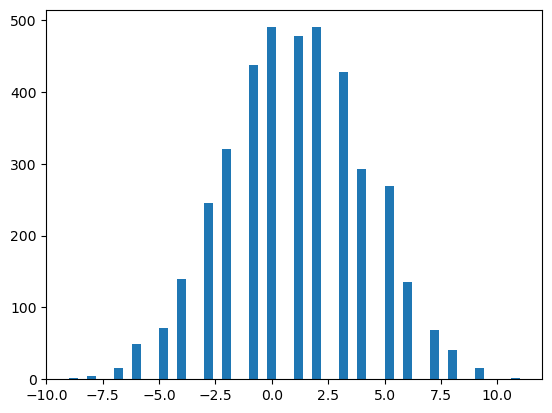

In [31]:
p1 = trace.posterior['p1'].values.flatten()
d1 = trace.posterior['d1'].values.flatten()
p2 = trace.posterior['p2'].values.flatten()
d2 = trace.posterior['d2'].values.flatten()

a1 = p1*d1
b1 = (1-p1)*d1
a2 = p2*d2
b2 = (1-p2)*d2

g1 = stats.betabinom(n=12,a=a1,b=b1).rvs()
g2 = stats.betabinom(n=12,a=a2,b=b2).rvs()

plt.hist(g1 - g2,bins=50);

# Thinking about generalizability

Often times, when we worry about sample size, what we really worry about is the *representativeness* of the sample. Does the sample in the study represent the important features of the general population? If you only study undergraduates at elite universities, how are you suppose to find out about everyone else? 

It can be nice to see that worries about representativeness and generalizability are actually quite different from worries about sample size. You could do a study on 10000 NYU undergraduates. You can learn any property of the NYU undergraduates with certainty. But that doesn't mean you have learned a lot about the psychology of people who work in trucking.

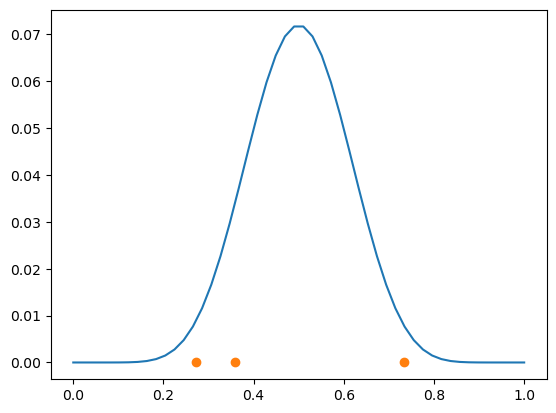

In [48]:
x = np.linspace(0,1)
y = stats.beta(a=10,b=10).pdf(x)
y = y / sum(y)

ps = stats.beta(a=5,b=5).rvs(3)

plt.plot(x,y)
plt.plot(ps,[0,0,0],'o')

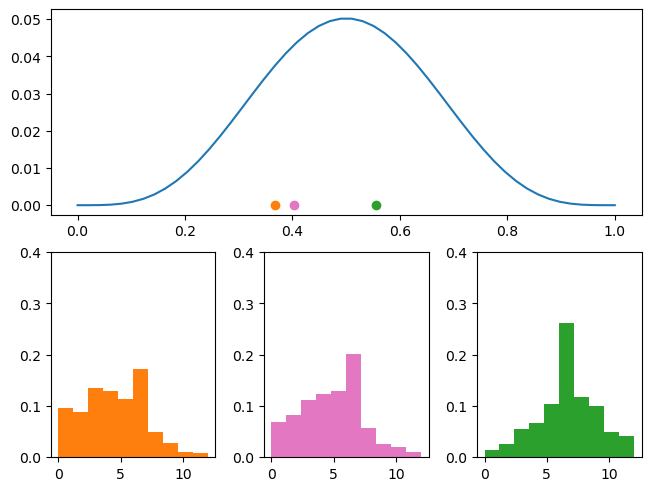

In [56]:
# population level parameters
# the error rate varys from group to group
# according to the beta distribution

p = 0.5
d = 10

dist_error_rate = stats.beta(a=p*d,b=(1-p)*d)

# subgroup level parameters
# each subgroup has 50 people
# and a dispersion of 10

sample_size = 1000
d = 10

# plot settings and generation

fig = plt.figure(constrained_layout=True).subplot_mosaic(
    """
    AAA
    BCD
    """)

x = np.linspace(0,1)
y = dist_error_rate.pdf(x)
y = y / sum(y)

ps = dist_error_rate.rvs(3)
ps = np.sort(ps)

fig['A'].plot(x,y)

plot_id = ['B','C','D']
plot_colors = ['tab:orange','tab:pink','tab:green']

for i in range(3):
    
    p = ps[i]

    data = stats.betabinom(n=12,a=p*d,b=(1-p)*d).rvs(sample_size)
    fig['A'].plot(p,[0],'o',color=plot_colors[i])
    fig[plot_id[i]].hist(data,bins=10,color=plot_colors[i],density=True)
    fig[plot_id[i]].set_ylim([0,0.4]);

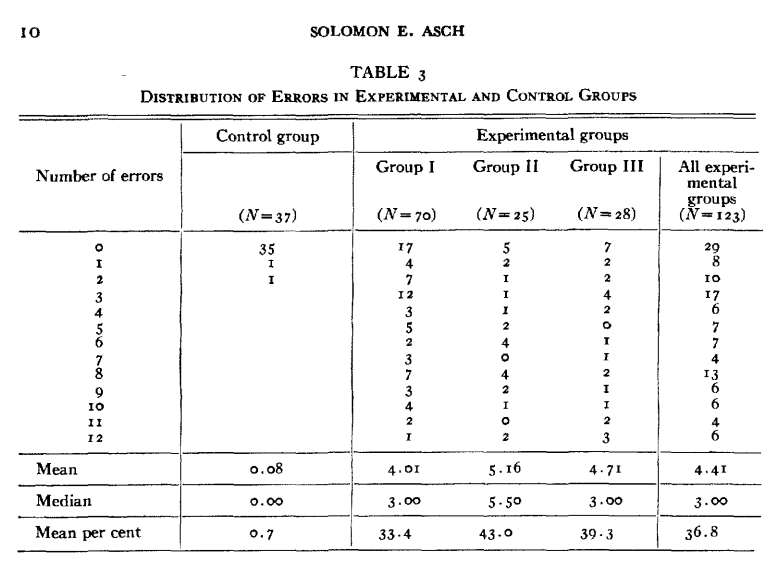